**Sections of this kernel**
- Project understanding
- Data understanding
- Data visualization
- Baseline model (Fastai v1)
- Validation and analysis
    - Metrics
    - Prediction and activation visualizations
    - ROC & AUC
- Submit
- Deploy (example)

Section: Data visualization | Section: Prediction and activation visualizations
:--------:|:-------:
<a href="https://ibb.co/5Mpm3ZF"><img src="https://i.ibb.co/gjqN8YV/metastases.png" alt="metastases" border="0" align=”right”></a> |<a href="https://ibb.co/Pc6wbyk"><img src="https://i.ibb.co/sKVyD47/gradcam.png" alt="gradcam" border="0"></a>

---------------------------------------------------
# Project understanding
###  What exactly is the problem?

**Binary image classification problem.** Identify the presence of metastases from 96 x 96px digital histopathology images. One key challenge is that the metastases can be as small as single cells in a large area of tissue.

### How would a solution look like?

**Our evaluation metric is [area under the ROC curve](http://en.wikipedia.org/wiki/Receiver_operating_characteristic).** The ROC curve is a plot of *True positive rate* against *False positive rate* at various thresholds and the area under the curve (AUC) is equal to the probability that a classifier will rank a randomly chosen positive instance higher than a randomly chosen negative one. The best possible solution would yield an AUC of 1 which means we would classify all positive samples correctly without getting any false positives. 

![ROC curve example](https://i.ibb.co/mBKh6ZB/roc.png)
<p style="text-align: center;"> ROC curve from a previous run of this kernel </p>

### What is known about the domain?

**The histopathological images are glass slide microscope images of lymph nodes that are stained with hematoxylin and eosin (H&E).** This staining method is one of the most widely used in medical diagnosis and it produces blue, violet and red colors. Dark blue hematoxylin binds to negatively charged substances such as nucleic acids and pink eosin to positively charged substances like amino-acid side chains (most proteins). Typically nuclei are stained blue, whereas cytoplasm and extracellular parts in various shades of pink.

**Low-resolution**             | **Mid-resolution**            | **High-resolution** 
:-------------------------:|:-------------------------:|:-------------------------:
![](https://camelyon17.grand-challenge.org/site/CAMELYON17/serve/public_html/example_low_resolution.png) | ![Example of a metastatic region](https://camelyon17.grand-challenge.org/site/CAMELYON17/serve/public_html/example_mid_resolution.png) | ![Example of a metastatic region](https://camelyon17.grand-challenge.org/site/CAMELYON17/serve/public_html/example_high_resolution.png)
**[<p style="text-align: center;"> Example of a metastatic region in lymph nodes, CHAMELYON17 </p>](https://camelyon17.grand-challenge.org/Background/)**

Lymph nodes are small glands that filter the fluid in the lymphatic system and they are the first place a breast cancer is likely to spread. Histological assessment of lymph node metastases is part of determining the stage of breast cancer in TNM classification which is a globally recognized standard for classifying the extent of spread of cancer. The diagnostic procedure for pathologists is tedious and time-consuming as a large area of tissue has to be examined and small metastases can be easily missed.

**Useful links for background knowledge**
- [Patch Camelyon (PCam)](https://github.com/basveeling/pcam)
- [Hematoxylin and eosin staining of tissue and cell sections](https://www.ncbi.nlm.nih.gov/pubmed/21356829)
- [H&E-stained sentinel lymph node sections of breast cancer patients: the CAMELYON dataset](https://academic.oup.com/gigascience/article/7/6/giy065/5026175)
- [CAMELYON16 - background](https://camelyon16.grand-challenge.org/Background/)
- [CAMELYON17 - background](https://camelyon17.grand-challenge.org/Background/)
- [TNM classification](https://www.uicc.org/resources/tnm)

----------------------------------------------
# Data understanding
### What data do we have available?

**220k training images and 57k evaluation images.** The dataset is a subset of the [PCam dataset](https://github.com/basveeling/pcam) and the only difference between these two is that all duplicate images have been removed. The PCam dataset is derived from the [Camelyon16 Challenge dataset](https://camelyon16.grand-challenge.org/Data/) which contains 400 H&E stained whole slide images of sentinel lymph node sections that were acquired and digitized at 2 different centers using a 40x objective. The PCam's dataset including this one uses 10x undersampling to increase the field of view, which gives the resultant pixel resolution of 2.43 microns.

According to the data description, there is a 50/50 balance between positive and negative examples in the training and test splits. However, **the training distribution seems to be 60/40 (negatives/positives)**. A positive label means that there is at least one pixel of tumor tissue in the center region (32 x 32px) of the image. **Tumor tissue in the outer region of the patch does not influence the label.** This means that a negatively labeled image could contain metastases in the outer region. Thus, it would be a good idea to crop the images to the center region.

**Image file descriptors**

Description | 
:--------:|:-------:
Format | TIF
Size | 96 x 96
Channels | 3
Bits per channel | 8
Data type | Unsigned char
Compression | Jpeg

### Is the data relevant to the problem?

This dataset is a combination of two independent datasets collected in Radboud University Medical Center (Nijmegen, the Netherlands), and the University Medical Center Utrecht (Utrecht, the Netherlands). The slides are produced by routine clinical practices and a trained pathologist would examine similar images for identifying metastases. However, some relevant information about the surroundings might be left out with these small-sized image samples.

### Is it valid? Does it reflect our expectations?

According to the data description, the dataset has been stripped of duplicates. However, this has not been confirmed by testing.

> For the entire dataset, when the slide-level label was unclear during the inspection of the H&E-stained slide, an additional WSI with a consecutive tissue section, immunohistochemically stained for cytokeratin, was used to confirm the classification.
- [1399 H&E-stained sentinel lymph node sections of breast cancer patients: the CAMELYON dataset](https://academic.oup.com/gigascience/article/7/6/giy065/5026175)

### Is the data quality, quantity, recency sufficient?

> All glass slides included in the CAMELYON dataset were part of routine clinical care and are thus of diagnostic quality. However, during the acquisition process, scanning can fail or result in out-of-focus images. As a quality-control measure, all slides were inspected manually after scanning. The inspection was performed by an experienced technician (Q.M. and N.S. for UMCU, M.H. or R.vd.L. for the other centers) to assess the quality of the scan; when in doubt, a pathologist was consulted on whether scanning issues might affect diagnosis.
- [1399 H&E-stained sentinel lymph node sections of breast cancer patients: the CAMELYON dataset](https://academic.oup.com/gigascience/article/7/6/giy065/5026175)

-----------------------------------------
# Data visualization

In [1]:
!pip install tqdm

In [2]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
from sklearn.utils import shuffle
from tqdm import tqdm_notebook

data = pd.read_csv('./train_labels.csv')
train_path = './train/'
test_path = './test/'
# quick look at the label stats
data['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

In [3]:
data.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


We can see that the negative/positive ratio is not entirely 50/50 as there are 130k negatives and 90k negatives. The ratio is closer to 60/40 meaning that there are 1.5 times more negative images than positives.

### Plot some images with and without cancer tissue for comparison

In [4]:
def readImage(path):
    # OpenCV reads the image in bgr format by default
    bgr_img = cv2.imread(path)
    # We flip it to rgb for visualization purposes
    b,g,r = cv2.split(bgr_img)
    rgb_img = cv2.merge([r,g,b])
    return rgb_img

Text(0, 0.5, 'Tumor tissue samples')

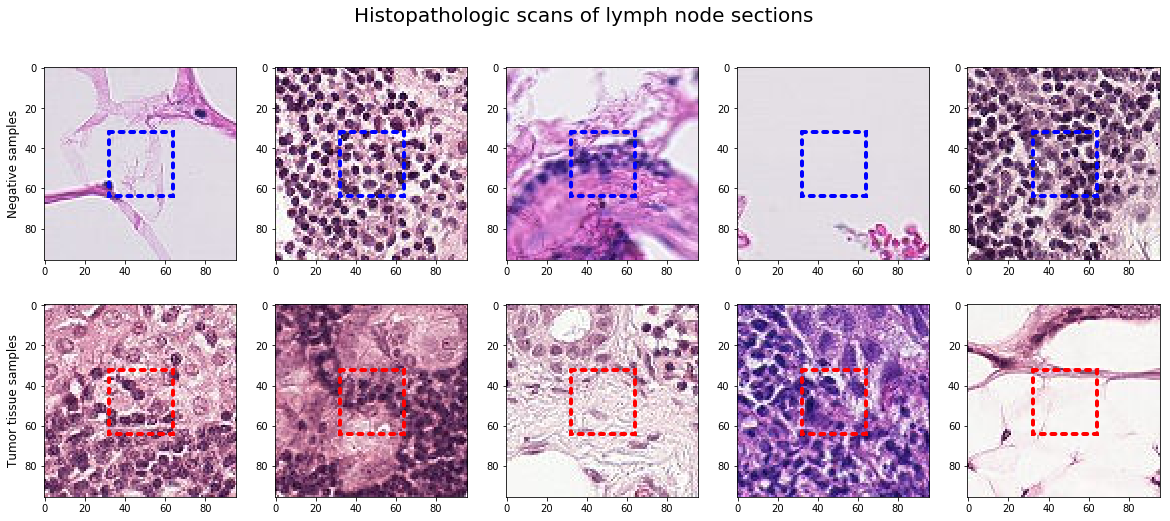

In [5]:
# random sampling
shuffled_data = shuffle(data)

fig, ax = plt.subplots(2,5, figsize=(20,8))
fig.suptitle('Histopathologic scans of lymph node sections',fontsize=20)
# Negatives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 0]['id'][:5]):
    path = os.path.join(train_path, idx)
    ax[0,i].imshow(readImage(path + '.tif'))
    # Create a Rectangle patch
    box = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='b',facecolor='none', linestyle=':', capstyle='round')
    ax[0,i].add_patch(box)
ax[0,0].set_ylabel('Negative samples', size='large')
# Positives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 1]['id'][:5]):
    path = os.path.join(train_path, idx)
    ax[1,i].imshow(readImage(path + '.tif'))
    # Create a Rectangle patch
    box = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='r',facecolor='none', linestyle=':', capstyle='round')
    ax[1,i].add_patch(box)
ax[1,0].set_ylabel('Tumor tissue samples', size='large')

Classifying metastases is probably not an easy task for a trained pathologist and extremely difficult for an untrained eye. According to [Libre Pathology](https://librepathology.org/wiki/Lymph_node_metastasis), lymph node metastases can have these features:

> - Foreign cell population - key feature (Classic location: subcapsular sinuses)
- Cells with cytologic features of malignancy
    - Nuclear pleomorphism (variation in size, shape and staining).
    - Nuclear atypia:
        - **Nuclear enlargement**.
        - **Irregular nuclear membrane**.
        - **Irregular chromatin pattern, esp. asymmetry**.
        - **Large or irregular nucleolus**.
     - Abundant mitotic figures.
- Cells in architectural arrangements seen in malignancy; highly variable - dependent on tumour type and differentiation.
    - Gland formation.
    - Single cells.
    - Small clusters of cells.
  
**The takeaway from this is probably that irregular nuclear shapes, sizes or staining shades can indicate metastases.**

### How is the data best transformed for modeling?

We know that the label of the image is influenced only by the center region (32 x 32px) so it would make sense to crop our data to that region only. However, some useful information about the surroundings could be lost if we crop too close.  This hypothesis could be confirmed by training models with varying crop sizes. My initial results with 32 x 32px size showed worse performance than with 48 x 48px but I haven't done a search for optimal size.

### How may we increase the data quality?

We could inspect if the data contains bad data (too unfocused or corrupted) and remove those to increase the overall quality.

### Preprocessing and augmentation
There are couple of ways we can use to avoid overfitting; more data, augmentation, regularization and less complex model architectures. Here we will define what image augmentations to use and add them directly to our image loader function. Note that if we apply augmentation here, augmentations will also be applied when we are predicting (inference). This is called test time augmentation (TTA) and it can improve our results if we run inference multiple times for each image and average out the predictions. 

**The augmentations we can use for this type of data:**
- random rotation
- random crop
- random flip (horizontal and vertical both)
- random lighting
- random zoom (not implemented here)
- Gaussian blur (not implemented here)

We will use OpenCV with image operations because in my experience, OpenCV is a lot faster than *PIL* or *scikit-image*.

In [6]:
import random
ORIGINAL_SIZE = 96      # original size of the images - do not change

# AUGMENTATION VARIABLES
CROP_SIZE = 90          # final size after crop
RANDOM_ROTATION = 3    # range (0-180), 180 allows all rotation variations, 0=no change
RANDOM_SHIFT = 2        # center crop shift in x and y axes, 0=no change. This cannot be more than (ORIGINAL_SIZE - CROP_SIZE)//2 
RANDOM_BRIGHTNESS = 7  # range (0-100), 0=no change
RANDOM_CONTRAST = 5    # range (0-100), 0=no change
RANDOM_90_DEG_TURN = 1  # 0 or 1= random turn to left or right

def readCroppedImage(path, augmentations = True):
    # augmentations parameter is included for counting statistics from images, where we don't want augmentations
    
    # OpenCV reads the image in bgr format by default
    bgr_img = cv2.imread(path)
    # We flip it to rgb for visualization purposes
    b,g,r = cv2.split(bgr_img)
    rgb_img = cv2.merge([r,g,b])
    
    if(not augmentations):
        return rgb_img / 255
    
    #random rotation
    rotation = random.randint(-RANDOM_ROTATION,RANDOM_ROTATION)
    if(RANDOM_90_DEG_TURN == 1):
        rotation += random.randint(-1,1) * 90
    M = cv2.getRotationMatrix2D((48,48),rotation,1)   # the center point is the rotation anchor
    rgb_img = cv2.warpAffine(rgb_img,M,(96,96))
    
    #random x,y-shift
    x = random.randint(-RANDOM_SHIFT, RANDOM_SHIFT)
    y = random.randint(-RANDOM_SHIFT, RANDOM_SHIFT)
    
    # crop to center and normalize to 0-1 range
    start_crop = (ORIGINAL_SIZE - CROP_SIZE) // 2
    end_crop = start_crop + CROP_SIZE
    rgb_img = rgb_img[(start_crop + x):(end_crop + x), (start_crop + y):(end_crop + y)] / 255
    
    # Random flip
    flip_hor = bool(random.getrandbits(1))
    flip_ver = bool(random.getrandbits(1))
    if(flip_hor):
        rgb_img = rgb_img[:, ::-1]
    if(flip_ver):
        rgb_img = rgb_img[::-1, :]
        
    # Random brightness
    br = random.randint(-RANDOM_BRIGHTNESS, RANDOM_BRIGHTNESS) / 100.
    rgb_img = rgb_img + br
    
    # Random contrast
    cr = 1.0 + random.randint(-RANDOM_CONTRAST, RANDOM_CONTRAST) / 100.
    rgb_img = rgb_img * cr
    
    # clip values to 0-1 range
    rgb_img = np.clip(rgb_img, 0, 1.0)
    
    return rgb_img

Text(0, 0.5, 'Tumor tissue samples')

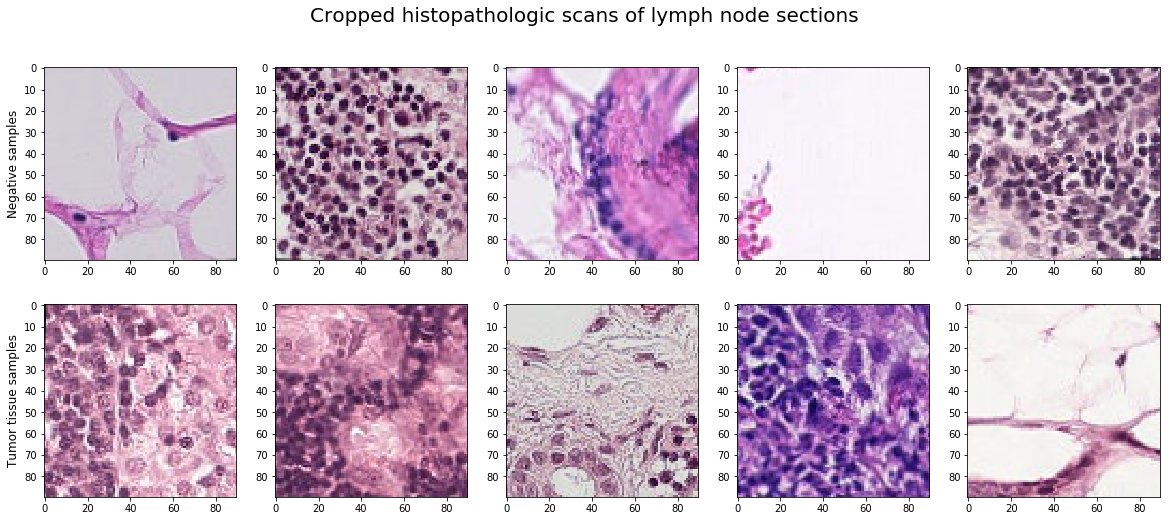

In [7]:
fig, ax = plt.subplots(2,5, figsize=(20,8))
fig.suptitle('Cropped histopathologic scans of lymph node sections',fontsize=20)
# Negatives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 0]['id'][:5]):
    path = os.path.join(train_path, idx)
    ax[0,i].imshow(readCroppedImage(path + '.tif'))
ax[0,0].set_ylabel('Negative samples', size='large')
# Positives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 1]['id'][:5]):
    path = os.path.join(train_path, idx)
    ax[1,i].imshow(readCroppedImage(path + '.tif'))
ax[1,0].set_ylabel('Tumor tissue samples', size='large')

**To see the effects of our augmentation, we can plot one image multiple times.**

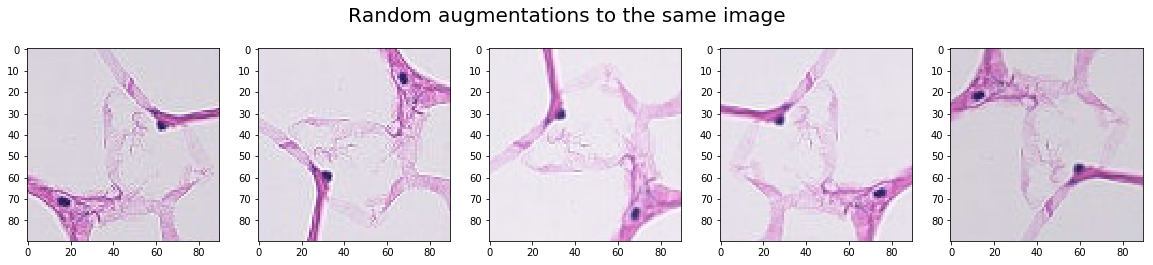

In [8]:
fig, ax = plt.subplots(1,5, figsize=(20,4))
fig.suptitle('Random augmentations to the same image',fontsize=20)
# Negatives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 0]['id'][:1]):
    for j in range(5):
        path = os.path.join(train_path, idx)
        ax[j].imshow(readCroppedImage(path + '.tif'))

### Compute image statistics
**Do not use augmentation here!**

Calculating statistics will give channel averages of [0.702447, 0.546243, 0.696453],
and std's of [0.238893, 0.282094, 0.216251].

While we are calculating statistics, we can check if there are images that have a very low maximum pixel intensity (almost totally black) or very high minimum pixel intensity (almost totally white). These kind of images could be caused by bad exposure or cropping to an empty area. In case of an empty area, the image would not be an outlier but equally valid negative sample.

We find that there is at least one very dark and 6 very bright images.

In [9]:
#!pip install ipywidgets
#!jupyter nbextension enable --py widgetsnbextension

In [10]:
# As we count the statistics, we can check if there are any completely black or white images
dark_th = 10 / 255      # If no pixel reaches this threshold, image is considered too dark
bright_th = 245 / 255   # If no pixel is under this threshold, image is considerd too bright
too_dark_idx = []
too_bright_idx = []

x_tot = np.zeros(3)
x2_tot = np.zeros(3)
counted_ones = 0
for i, idx in tqdm_notebook(enumerate(shuffled_data['id']), 'computing statistics...(220025 it total)'):
    path = os.path.join(train_path, idx)
    imagearray = readCroppedImage(path + '.tif', augmentations = False).reshape(-1,3)
    # is this too dark
    if(imagearray.max() < dark_th):
        too_dark_idx.append(idx)
        continue # do not include in statistics
    # is this too bright
    if(imagearray.min() > bright_th):
        too_bright_idx.append(idx)
        continue # do not include in statistics
    x_tot += imagearray.mean(axis=0)
    x2_tot += (imagearray**2).mean(axis=0)
    counted_ones += 1
    
channel_avr = x_tot/counted_ones
channel_std = np.sqrt(x2_tot/counted_ones - channel_avr**2)
channel_avr,channel_std

KeyboardInterrupt: 

In [8]:
print('There was {0} extremely dark image'.format(len(too_dark_idx)))
print('and {0} extremely bright images'.format(len(too_bright_idx)))
print('Dark one:')
print(too_dark_idx)
print('Bright ones:')
print(too_bright_idx)

There was 1 extremely dark image
and 6 extremely bright images
Dark one:
['9369c7278ec8bcc6c880d99194de09fc2bd4efbe']
Bright ones:
['f6f1d771d14f7129a6c3ac2c220d90992c30c10b', '9071b424ec2e84deeb59b54d2450a6d0172cf701', 'c448cd6574108cf14514ad5bc27c0b2c97fc1a83', '54df3640d17119486e5c5f98019d2a92736feabc', '5f30d325d895d873d3e72a82ffc0101c45cba4a8', '5a268c0241b8510465cb002c4452d63fec71028a']


### Plot some of the very bright or very dark images

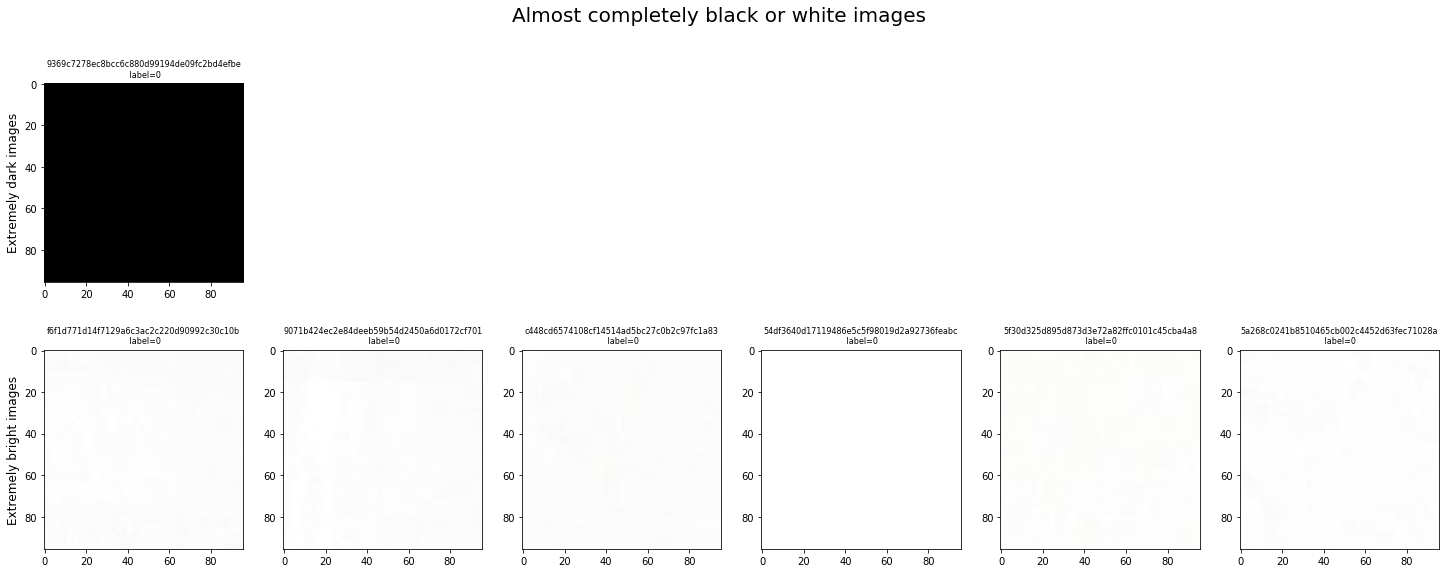

In [9]:
fig, ax = plt.subplots(2,6, figsize=(25,9))
fig.suptitle('Almost completely black or white images',fontsize=20)
# Too dark
i = 0
for idx in np.asarray(too_dark_idx)[:min(6, len(too_dark_idx))]:
    lbl = shuffled_data[shuffled_data['id'] == idx]['label'].values[0]
    path = os.path.join(train_path, idx)
    ax[0,i].imshow(readCroppedImage(path + '.tif', augmentations = False))
    ax[0,i].set_title(idx + '\n label=' + str(lbl), fontsize = 8)
    i += 1
ax[0,0].set_ylabel('Extremely dark images', size='large')
for j in range(min(6, len(too_dark_idx)), 6):
    ax[0,j].axis('off') # hide axes if there are less than 6
# Too bright
i = 0
for idx in np.asarray(too_bright_idx)[:min(6, len(too_bright_idx))]:
    lbl = shuffled_data[shuffled_data['id'] == idx]['label'].values[0]
    path = os.path.join(train_path, idx)
    ax[1,i].imshow(readCroppedImage(path + '.tif', augmentations = False))
    ax[1,i].set_title(idx + '\n label=' + str(lbl), fontsize = 8)
    i += 1
ax[1,0].set_ylabel('Extremely bright images', size='large')
for j in range(min(6, len(too_bright_idx)), 6):
    ax[1,j].axis('off') # hide axes if there are less than 6

All the dark and bright images are labeled negative. I think the bright ones are just cropped from a non-stained part or they don't have any tissue (plain glass?) so the labels are correct. The samples don't have tumor tissue present. I am not so sure about the dark image, is it an outlier crop from badly exposed area or just some very large cell part filling the whole image. Anyway, removing only a small amount of outliers from this size data set has little or no effect on the prediction performance.

-----------------------------------------

# Baseline model (Fastai v1)
In ML production pipeline, it is a good idea to start with a relatively simple model, sort of a minimum viable product (MVP) or a baseline. With MVP, we can very quickly see if there are some unexpected problems like bad data quality that will make any further investments into the model tuning not worth it.

### Prepare the data and split train
Split train data to 90% training and 10% validation parts. We want to maintain equal ratios of negative/positive (60/40) in both, training and test splits. This is not so crucial here as both labels are almost equally represented but in case we had a rare class, random split could cause severe underrepresentation or in worst case, leave all rare classes out of one split. 

In [11]:
from sklearn.model_selection import train_test_split

# we read the csv file earlier to pandas dataframe, now we set index to id so we can perform
train_df = data.set_index('id')

#If removing outliers, uncomment the four lines below
#print('Before removing outliers we had {0} training samples.'.format(train_df.shape[0]))
#train_df = train_df.drop(labels=too_dark_idx, axis=0)
#train_df = train_df.drop(labels=too_bright_idx, axis=0)
#print('After removing outliers we have {0} training samples.'.format(train_df.shape[0]))

train_names = train_df.index.values
train_labels = np.asarray(train_df['label'].values)

# split, this function returns more than we need as we only need the validation indexes for fastai
tr_n, tr_idx, val_n, val_idx = train_test_split(train_names, range(len(train_names)), test_size=0.1, stratify=train_labels, random_state=123)

We will use [**Fast.ai V1**](https://docs.fast.ai/) software library that is built on [PyTorch](https://pytorch.org/). What I like about Fast.ai is that it includes "out of the box" support for many recent advancements in deep learning research. If you want to use the 0.7 version of Fast.ai, see commit version 9 of this kernel.

I highly recommend the [Fastai: practical deep learning course for coders, v3](https://course.fast.ai/).

I want to thank [Martijn](https://www.kaggle.com/etinuz) for sharing his examples of Fastai v1 training and visualization! They were helpful when converting this kernel from Fastai v0.7 to v1.0.

### What kind of model architecture suits the problem best?

Here we will be using a pretrained convnet model and transfer learning to adjust the weights to our data. Going for a deeper model architecture will start overfitting faster.

For differenet pretrained model architectures, check [Fast.ai vision models](https://docs.fast.ai/vision.models.html) and [torchvision models](https://pytorch.org/docs/stable/torchvision/models.html).

In [13]:
!pip install http://download.pytorch.org/whl/cpu/torch-1.0.0-cp36-cp36m-linux_x86_64.whl

torch-1.0.0-cp36-cp36m-linux_x86_64.whl is not a supported wheel on this platform.


In [12]:
# fastai 1.0
from fastai import *
from fastai.vision import *
from torchvision.models import *    # import *=all the models from torchvision  

arch = densenet169                  # specify model architecture, densenet169 seems to perform well for this data but you could experiment
BATCH_SIZE = 128                    # specify batch size, hardware restrics this one. Large batch sizes may run out of GPU memory
sz = CROP_SIZE                      # input size is the crop size
MODEL_PATH = str(arch).split()[1]   # this will extrat the model name as the model file name e.g. 'resnet50'

ModuleNotFoundError: No module named 'fastai'

We load the images to an ImageDataBunch for the training. This fastai's data object is easily customized for loading images using our own `readCroppedImage` function. We just need to subclass ImageList. 
[Data API docs](https://docs.fast.ai/data_block.html)

In [12]:
# create dataframe for the fastai loader
train_dict = {'name': train_path + train_names, 'label': train_labels}
df = pd.DataFrame(data=train_dict)
# create test dataframe
test_names = []
for f in os.listdir(test_path):
    test_names.append(test_path + f)
df_test = pd.DataFrame(np.asarray(test_names), columns=['name'])

In [13]:
# Subclass ImageList to use our own image opening function
class MyImageItemList(ImageList):
    def open(self, fn:PathOrStr)->Image:
        img = readCroppedImage(fn.replace('/./','').replace('//','/'))
        # This ndarray image has to be converted to tensor before passing on as fastai Image, we can use pil2tensor
        return vision.Image(px=pil2tensor(img, np.float32))
    

In [14]:
# Create ImageDataBunch using fastai data block API
imgDataBunch = (MyImageItemList.from_df(path='/', df=df, suffix='.tif')
        #Where to find the data?
        .split_by_idx(val_idx)
        #How to split in train/valid?
        .label_from_df(cols='label')
        #Where are the labels?
        .add_test(MyImageItemList.from_df(path='/', df=df_test))
        #dataframe pointing to the test set?
        .transform(tfms=[[],[]], size=sz)
        # We have our custom transformations implemented in the image loader but we could apply transformations also here
        # Even though we don't apply transformations here, we set two empty lists to tfms. Train and Validation augmentations
        .databunch(bs=BATCH_SIZE)
        # convert to databunch
        .normalize([tensor([0.702447, 0.546243, 0.696453]), tensor([0.238893, 0.282094, 0.216251])])
        # Normalize with training set stats. These are means and std's of each three channel and we calculated these previously in the stats step.
       )

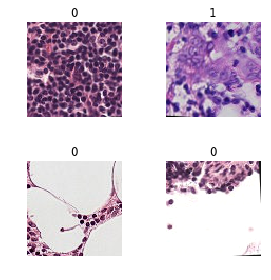

In [15]:
# check that the imgDataBunch is loading our images ok
imgDataBunch.show_batch(rows=2, figsize=(4,4))

### Training
We define a convnet learner object where we set the model architecture and our data bunch.
[`create_cnn` docs.fast.ai](https://docs.fast.ai/vision.learner.html#create_cnn)

In [16]:
# Next, we create a convnet learner object
# ps = dropout percentage (0-1) in the final layer
def getLearner():
    return create_cnn(imgDataBunch, arch, pretrained=True, path='.', metrics=accuracy, ps=0.5, callback_fns=ShowGraph)

learner = getLearner()

Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /tmp/.torch/models/densenet169-b2777c0a.pth
100%|██████████| 57365526/57365526 [00:00<00:00, 84352985.26it/s]


### 1cycle policy
We will use the one cycle policy proposed by Leslie Smith, [arXiv, April 2018](https://arxiv.org/abs/1803.09820). The policy brings more disciplined approach for selecting hyperparameters such as learning rate and weight decay.** This can potentially save us a lot of time from training with suboptimal hyperparameters.** In addititon, Fastai library has implemented a training function for one cycle policy that we can use with only a few lines of code.

Sylvian Gugger wrote a very clear [explanation](https://sgugger.github.io/the-1cycle-policy.html) of Leslie's proposal that I recommend for reading.

First, we find the optimal `learning rate` and `weight decay` values. The optimal lr is just before the base of the loss and before the start of divergence. It is important that the loss is still descending where we select the learning rate.

As for the `weight decay` that is the L2 penalty of the optimizer, Leslie proposes to select the largest one that will still let us train at a high learning rate so we do a small grid search with 1e-2, 1e-4 and 1e-6 weight decays.

In [17]:
# We can use lr_find with different weight decays and record all losses so that we can plot them on the same graph
# Number of iterations is by default 100, but at this low number of itrations, there might be too much variance
# from random sampling that makes it difficult to compare WD's. I recommend using an iteration count of at least 300 for more consistent results.
lrs = []
losses = []
wds = []
iter_count = 600

# WEIGHT DECAY = 1e-6
learner.lr_find(wd=1e-6, num_it=iter_count)
lrs.append(learner.recorder.lrs)
losses.append(learner.recorder.losses)
wds.append('1e-6')
learner = getLearner() #reset learner - this gets more consistent starting conditions

# WEIGHT DECAY = 1e-4
learner.lr_find(wd=1e-4, num_it=iter_count)
lrs.append(learner.recorder.lrs)
losses.append(learner.recorder.losses)
wds.append('1e-4')
learner = getLearner() #reset learner - this gets more consistent starting conditions

# WEIGHT DECAY = 1e-2
learner.lr_find(wd=1e-2, num_it=iter_count)
lrs.append(learner.recorder.lrs)
losses.append(learner.recorder.losses)
wds.append('1e-2')
learner = getLearner() #reset learner

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


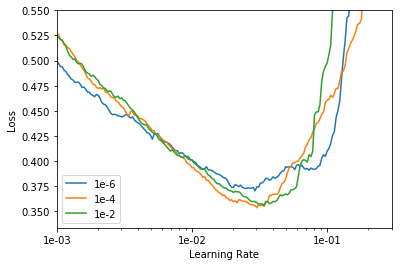

In [18]:
# Plot weight decays
_, ax = plt.subplots(1,1)
min_y = 0.5
max_y = 0.55
for i in range(len(losses)):
    ax.plot(lrs[i], losses[i])
    min_y = min(np.asarray(losses[i]).min(), min_y)
ax.set_ylabel("Loss")
ax.set_xlabel("Learning Rate")
ax.set_xscale('log')
#ax ranges may need some tuning with different model architectures 
ax.set_xlim((1e-3,3e-1))
ax.set_ylim((min_y - 0.02,max_y))
ax.legend(wds)
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))

**We want to select the largest weight decay that gets to a low loss and has the highest learning rate before shooting up.**
Out of the tested WD's, 1e-4 seems like the largest WD that allow us to train with maximal learning rate. *Note that the plot above may differ between runs as we use a random subset of data for computations.*

> Smaller datasets and architectures seem to require larger values for weight decay while larger datasets and deeper architectures seem to require smaller values. 
[Leslie  Smith](https://arxiv.org/pdf/1803.09820.pdf)

We can select the `learning rate` around 2e-2 where it is close to the bottom but still descending.

Next, we train only the heads while keeping the rest of the model frozen. Otherwise, the random initialization of the head weights could harm the relatively well-performing pre-trained weights of the model. After the heads have adjusted and the model somewhat works, we can continue to train all the weights.

epoch,train_loss,valid_loss,accuracy,time
1,0.223598,0.235617,0.908376,13:57
2,0.219223,0.209775,0.918602,13:44


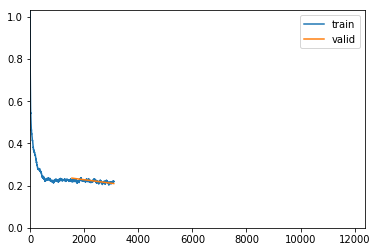

In [19]:
max_lr = 2e-2
wd = 1e-4
# 1cycle policy
learner.fit_one_cycle(cyc_len=8, max_lr=max_lr, wd=wd)

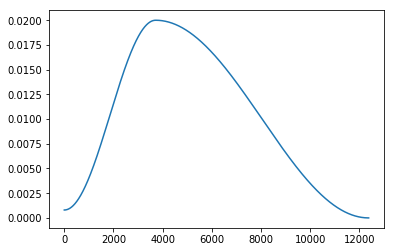

In [20]:
# plot learning rate of the one cycle
learner.recorder.plot_lr()

We can see that the learning rate starts from lower and reaches the `max_lr` in the middle. Then it slows back down near the end. The idea is that we start with a low warm-up learning rate and gradually increase it to high. The higher rate is having a regularizing effect as it won't allow the model to settle for sharp and narrow local minima but pushes for wider and more stable one.

In the middle of our cycle, we start to lower the learning rate as we are hopefully in a good stable area. This means that we start to look for the minima within that area.

## Is the model learning?
Our model should have already learned something and if it hasn't, there's probably something wrong with our code or with the data. 

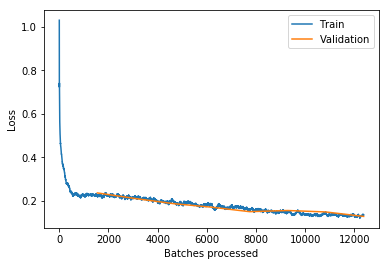

In [21]:
# and plot the losses of the first cycle
learner.recorder.plot_losses()

We can see from the plotted losses that there is a small rise after the initial drop which is caused by the increasing learning rate of the first half cycle. The losses are temporarily rising when `max_lr` drives the model out of local minima but this will pay off in the end when the learning rates are decreased.

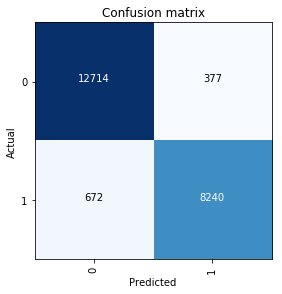

In [22]:
# predict the validation set with our model
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix(title='Confusion matrix')

**Confusion matrix** can help us understand the ratio of false negatives and positives and it's a fast way looking at our model's performance. This is a simple table that shows the counts in a way of actual label vs. predicted label. Here we can see that the model has learned to distinguish tumor and negative sample and it's already performing well. However, we will continue training further to improve from here.

In [23]:
# before we continue, lets save the model at this stage
learner.save(MODEL_PATH + '_stage1')

# Finetuning the baseline model
Next, we can unfreeze all the trainable parameters from the model and continue its training. 

The model already performs well and now, as we unfreeze the bottom layers that have been pre-trained with a large number of general images to detect common shapes and patterns, all weights are mostly adjusted. We should now train with much lower learning rates.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


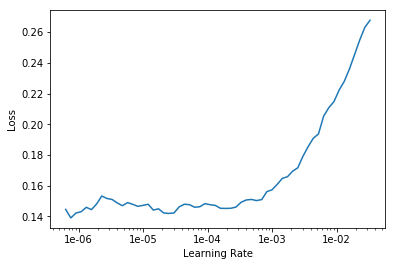

In [24]:
# load the baseline model
learner.load(MODEL_PATH + '_stage1')

# unfreeze and run learning rate finder again
learner.unfreeze()
learner.lr_find(wd=wd)

# plot learning rate finder results
learner.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
1,0.131308,0.126314,0.954779,17:40
2,0.133659,0.136755,0.949552,17:42


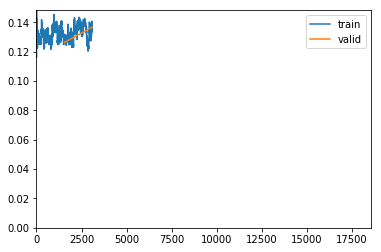

In [25]:
# Now, smaller learning rates. This time we define the min and max lr of the cycle
learner.fit_one_cycle(cyc_len=12, max_lr=slice(4e-5,4e-4))

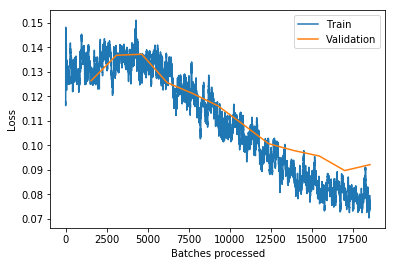

In [26]:
learner.recorder.plot_losses()

We can see that the validation performance has separated from the training performance a bit in the end of the cycle. This means that our model has started overfitting during the small learning rates. Now, if we would train further, the model would only memorize features from the training set and the validation set performance would rise. This is a good place to stop.  

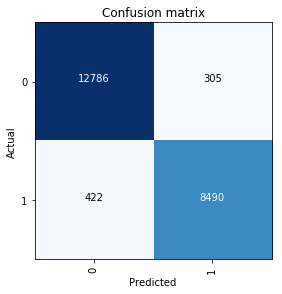

In [27]:
# lets take a second look at the confusion matrix. See if how much we improved.
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix(title='Confusion matrix')

In [28]:
# Save the finetuned model
learner.save(MODEL_PATH + '_stage2')

In [29]:
# if the model was better before finetuning, uncomment this to load the previous stage
#learner.load(MODEL_PATH + '_stage1')

-------------------------
# Validation and analysis
Now the training is done.

### How good does the model perform technically?

We can only get metrics from our validation set, and the final test metrics will be most likely a bit different.

In [30]:
preds,y, loss = learner.get_preds(with_loss=True)
# get accuracy
acc = accuracy(preds, y)
print('The accuracy is {0} %.'.format(acc))

The accuracy is 0.9673226475715637 %.


### How good is the model in terms of project requirements?
It is a good idea to look at examples of images from:

- Random samples
    - Some random predictions
- The most incorrectly labeled
    - What our model predicts wrong with very high probability.
- The most correctly labeled
    - What our model is most confident of and gets right.
    
This visualization is a good way of understanding what are the images the model struggles with. It might also reveal something about the dataset such as bad quality data.

In [31]:
# I modified this from the fastai's plot_top_losses (https://github.com/fastai/fastai/blob/master/fastai/vision/learner.py#L114)
from random import randint

def plot_overview(interp:ClassificationInterpretation, classes=['Negative','Tumor']):
    # top losses will return all validation losses and indexes sorted by the largest first
    tl_val,tl_idx = interp.top_losses()
    #classes = interp.data.classes
    fig, ax = plt.subplots(3,4, figsize=(16,12))
    fig.suptitle('Predicted / Actual / Loss / Probability',fontsize=20)
    # Random
    for i in range(4):
        random_index = randint(0,len(tl_idx))
        idx = tl_idx[random_index]
        im,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        im = image2np(im.data)
        cl = int(cl)
        ax[0,i].imshow(im)
        ax[0,i].set_xticks([])
        ax[0,i].set_yticks([])
        ax[0,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.probs[idx][cl]:.2f}')
    ax[0,0].set_ylabel('Random samples', fontsize=16, rotation=0, labelpad=80)
    # Most incorrect or top losses
    for i in range(4):
        idx = tl_idx[i]
        im,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        im = image2np(im.data)
        ax[1,i].imshow(im)
        ax[1,i].set_xticks([])
        ax[1,i].set_yticks([])
        ax[1,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.probs[idx][cl]:.2f}')
    ax[1,0].set_ylabel('Most incorrect\nsamples', fontsize=16, rotation=0, labelpad=80)
    # Most correct or least losses
    for i in range(4):
        idx = tl_idx[len(tl_idx) - i - 1]
        im,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        im = image2np(im.data)
        ax[2,i].imshow(im)
        ax[2,i].set_xticks([])
        ax[2,i].set_yticks([])
        ax[2,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.probs[idx][cl]:.2f}')
    ax[2,0].set_ylabel('Most correct\nsamples', fontsize=16, rotation=0, labelpad=80)

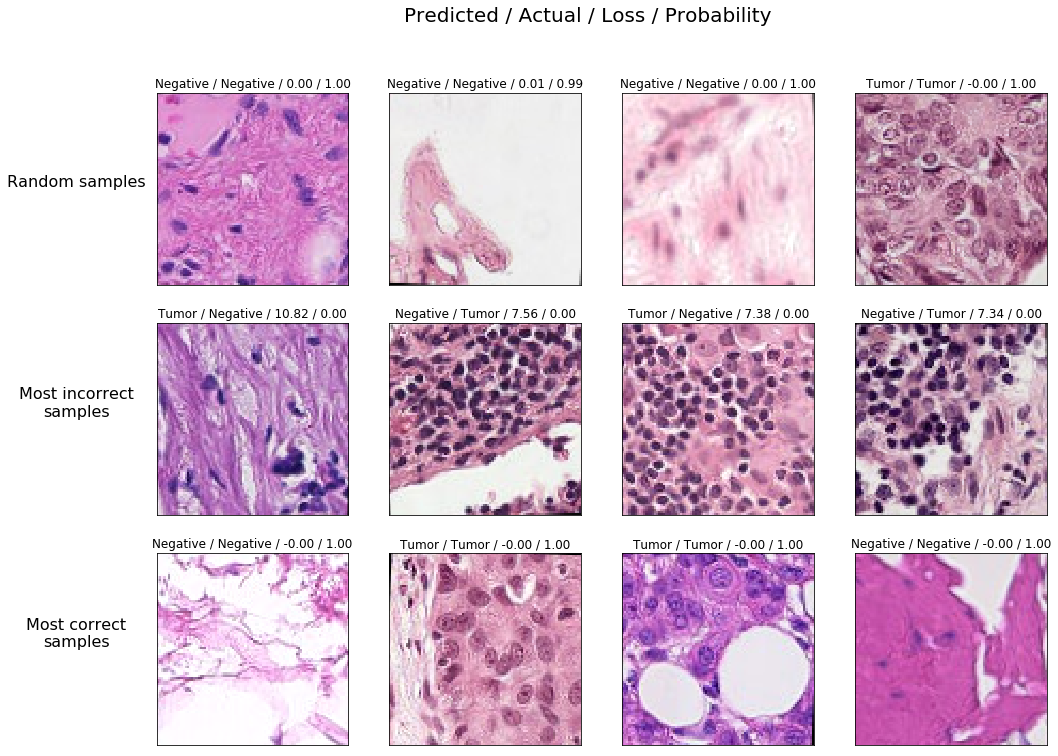

In [32]:
#interp = ClassificationInterpretation.from_learner(learner)
plot_overview(interp, ['Negative','Tumor'])

### Gradient-weighted Class Activation Mapping (Grad-CAM)
[Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391)

This method produces a coarse localization map highlighting the areas that the model considers important for the classification decision. The visual explanation gives transparency to the model making it easier to notice if it has learned the wrong things. For example, if we would train a dog breed classifier and all of our images of a certain dog breed would have been taken in a dog show competition. There is a good chance that the model would learn to recognize the competition surroundings instead of doggy features with that breed. Visualizing the localization map would reveal that, and we could focus on getting more diverse data of that breed.  

In [33]:
from fastai.callbacks.hooks import *

# hook into forward pass
def hooked_backward(m, oneBatch, cat):
    # we hook into the convolutional part = m[0] of the model
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(oneBatch)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [34]:
# We can create a utility function for getting a validation image with an activation map
def getHeatmap(val_index):
    """Returns the validation set image and the activation map"""
    # this gets the model
    m = learner.model.eval()
    tensorImg,cl = imgDataBunch.valid_ds[val_index]
    # create a batch from the one image
    oneBatch,_ = imgDataBunch.one_item(tensorImg)
    oneBatch_im = vision.Image(imgDataBunch.denorm(oneBatch)[0])
    # convert batch tensor image to grayscale image with opencv
    cvIm = cv2.cvtColor(image2np(oneBatch_im.data), cv2.COLOR_RGB2GRAY)
    # attach hooks
    hook_a,hook_g = hooked_backward(m, oneBatch, cl)
    # get convolutional activations and average from channels
    acts = hook_a.stored[0].cpu()
    #avg_acts = acts.mean(0)

    # Grad-CAM
    grad = hook_g.stored[0][0].cpu()
    grad_chan = grad.mean(1).mean(1)
    grad.shape,grad_chan.shape
    mult = (acts*grad_chan[...,None,None]).mean(0)
    return mult, cvIm

In [35]:
# Then, modify our plotting func a bit
def plot_heatmap_overview(interp:ClassificationInterpretation, classes=['Negative','Tumor']):
    # top losses will return all validation losses and indexes sorted by the largest first
    tl_val,tl_idx = interp.top_losses()
    #classes = interp.data.classes
    fig, ax = plt.subplots(3,4, figsize=(16,12))
    fig.suptitle('Grad-CAM\nPredicted / Actual / Loss / Probability',fontsize=20)
    # Random
    for i in range(4):
        random_index = randint(0,len(tl_idx))
        idx = tl_idx[random_index]
        act, im = getHeatmap(idx)
        H,W = im.shape
        _,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        ax[0,i].imshow(im)
        ax[0,i].imshow(im, cmap=plt.cm.gray)
        ax[0,i].imshow(act, alpha=0.5, extent=(0,H,W,0),
              interpolation='bilinear', cmap='inferno')
        ax[0,i].set_xticks([])
        ax[0,i].set_yticks([])
        ax[0,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.probs[idx][cl]:.2f}')
    ax[0,0].set_ylabel('Random samples', fontsize=16, rotation=0, labelpad=80)
    # Most incorrect or top losses
    for i in range(4):
        idx = tl_idx[i]
        act, im = getHeatmap(idx)
        H,W = im.shape
        _,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        ax[1,i].imshow(im)
        ax[1,i].imshow(im, cmap=plt.cm.gray)
        ax[1,i].imshow(act, alpha=0.5, extent=(0,H,W,0),
              interpolation='bilinear', cmap='inferno')
        ax[1,i].set_xticks([])
        ax[1,i].set_yticks([])
        ax[1,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.probs[idx][cl]:.2f}')
    ax[1,0].set_ylabel('Most incorrect\nsamples', fontsize=16, rotation=0, labelpad=80)
    # Most correct or least losses
    for i in range(4):
        idx = tl_idx[len(tl_idx) - i - 1]
        act, im = getHeatmap(idx)
        H,W = im.shape
        _,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        ax[2,i].imshow(im)
        ax[2,i].imshow(im, cmap=plt.cm.gray)
        ax[2,i].imshow(act, alpha=0.5, extent=(0,H,W,0),
              interpolation='bilinear', cmap='inferno')
        ax[2,i].set_xticks([])
        ax[2,i].set_yticks([])
        ax[2,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.probs[idx][cl]:.2f}')
    ax[2,0].set_ylabel('Most correct\nsamples', fontsize=16, rotation=0, labelpad=80)

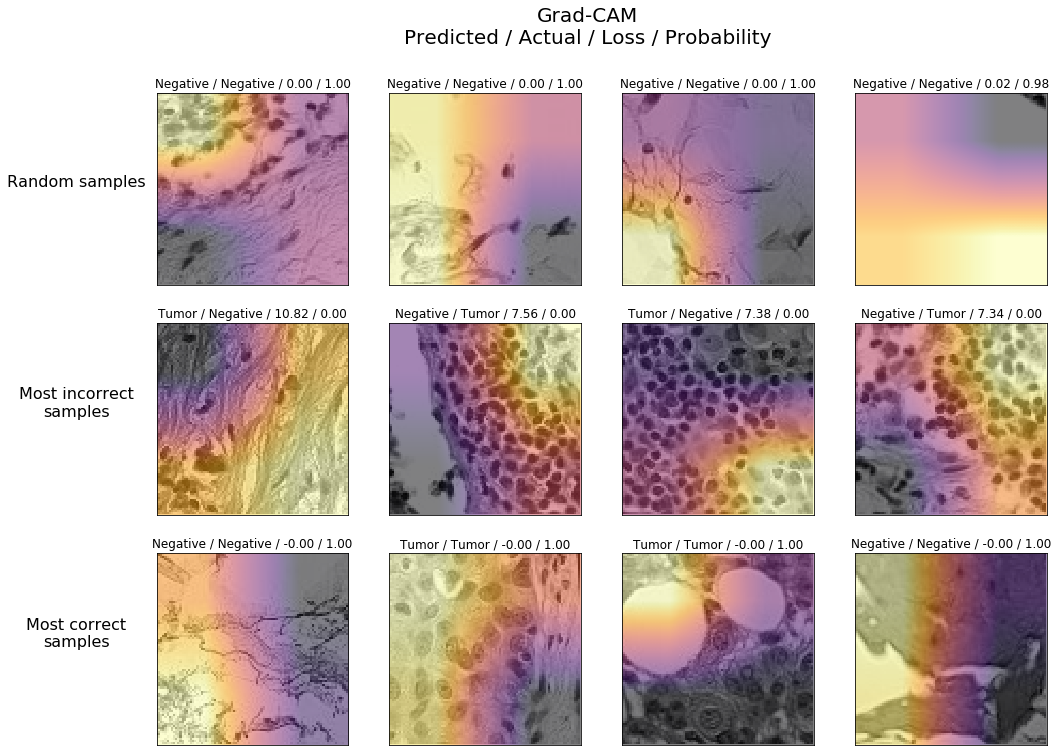

In [36]:
plot_heatmap_overview(interp, ['Negative','Tumor'])

This shows the activation maps of the predicted category so if the label is ```tumor```, the visualization shows all the places where the model thinks the tumor patterns are.

### ROC curve and AUC
Remember, AUC is the metric that is used for evaluating submissions. We can calculate it here for ou validation set but it will most likely differ from the final score.

In [37]:
from sklearn.metrics import roc_curve, auc
# probs from log preds
probs = np.exp(preds[:,1])
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y, probs, pos_label=1)

# Compute ROC area
roc_auc = auc(fpr, tpr)
print('ROC area is {0}'.format(roc_auc))

ROC area is 0.9942634117111718


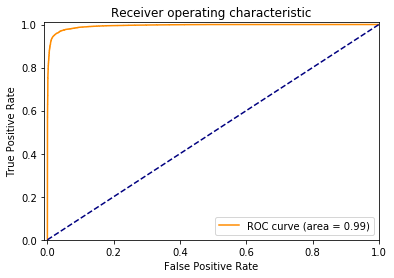

In [38]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

----------------

# Submit predictions
### TTA
To evaluate the model, we run inference on all test images. As we have test time augmentation, our results will probably improve if we do predictions multiple times per image and average out the results. 

In [39]:
# make sure we have the best performing model stage loaded
learner.load(MODEL_PATH + '_stage2')

# Fastai has a function for this but we don't want the additional augmentations it does (our image loader has augmentations) so we just use the get_preds
#preds_test,y_test=learner.TTA(ds_type=DatasetType.Test)

# We do a fair number of iterations to cover different combinations of flips and rotations.
# The predictions are then averaged.
n_aug = 12
preds_n_avg = np.zeros((len(learner.data.test_ds.items),2))
for n in tqdm_notebook(range(n_aug), 'Running TTA...'):
    preds,y = learner.get_preds(ds_type=DatasetType.Test, with_loss=False)
    preds_n_avg = np.sum([preds_n_avg, preds.numpy()], axis=0)
preds_n_avg = preds_n_avg / n_aug

In [40]:
# Next, we will transform class probabilities to just tumor class probabilities
print('Negative and Tumor Probabilities: ' + str(preds_n_avg[0]))
tumor_preds = preds_n_avg[:, 1]
print('Tumor probability: ' + str(tumor_preds[0]))
# If we wanted to get the predicted class, argmax would get the index of the max
class_preds = np.argmax(preds_n_avg, axis=1)
classes = ['Negative','Tumor']
print('Class prediction: ' + classes[class_preds[0]])

Negative and Tumor Probabilities: [9.999999e-01 9.291228e-08]
Tumor probability: 9.291228083204335e-08
Class prediction: Negative


### Submit the model for evaluation
We need to submit the tumor probability for each test sample in this competition. The probability ranges from 0 to 1.

In [41]:
# get test id's from the sample_submission.csv and keep their original order
SAMPLE_SUB = '/kaggle/input/sample_submission.csv'
sample_df = pd.read_csv(SAMPLE_SUB)
sample_list = list(sample_df.id)

# List of tumor preds. 
# These are in the order of our test dataset and not necessarily in the same order as in sample_submission
pred_list = [p for p in tumor_preds]

# To know the id's, we create a dict of id:pred
pred_dic = dict((key, value) for (key, value) in zip(learner.data.test_ds.items, pred_list))

# Now, we can create a new list with the same order as in sample_submission
pred_list_cor = [pred_dic['///kaggle/input/test/' + id + '.tif'] for id in sample_list]

# Next, a Pandas dataframe with id and label columns.
df_sub = pd.DataFrame({'id':sample_list,'label':pred_list_cor})

# Export to csv
df_sub.to_csv('{0}_submission.csv'.format(MODEL_PATH), header=True, index=False)

In [42]:
# This is what the first 10 items of submission look like
df_sub.head(10)

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0.001712
1,95596b92e5066c5c52466c90b69ff089b39f2737,0.010501
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0.000041
3,2c35657e312966e9294eac6841726ff3a748febf,0.002837
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0.000108
5,725dabe6ecccc68b958a2c7dd75bcbf362c7cb03,0.998144
6,aa0307865281d4484ddf8c637c348292968b93a7,0.284006
7,f4e5dc9c949920f1b3362982e15e99bf6f3ef83b,0.271936
8,95e08c9cedc28a9b4a86f4fc1e06c1972134be08,0.002006
9,ee1f5345a8d4e28403b7e61b97b5f76c201ce9cb,0.007625


--------------------------------------------------------------

# Deploy (example)
Now that we have a working model. We could deploy this for inference to another machine, a web server for example.
For this, we need our saved model, and then we need to export the  DataBunch.

**Note**. I haven't tried these so I cannot guarantee these will work straight away. You may need to do some debugging. [Official documentation](https://docs.fast.ai/tutorial.inference.html).

In [43]:
# This will create an export.pkl file that you'll need to copy with your model file if you want to deploy it on another device.
# This saves the internal information (classes, etc) need for inference in a file named 'export.pkl'. 
imgDataBunch.export(fname='./export.pkl')

**On a new machine**
We need to create an empty DataBunch and load it to a learner.

In [44]:
######## RUN THIS ON A NEW MACHINE ##########
#from fastai.vision import * # fastai 1.0
#from fastai import *
#from torchvision.models import *
#arch = densenet169       # specify model architecture
#MODEL_PATH = str(arch).split()[1] + '_stage2'
#empty_data = ImageDataBunch.load_empty('./') #this will look for a file named export.pkl in the specified path
#learner = create_cnn(empty_data, arch).load(MODEL_PATH)

This is a negative tissue image.


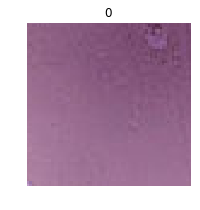

In [45]:
## And then we are ready to do predictions
import cv2
sz = 68

# This function will convert image to the prediction format
def imageToTensorImage(path):
    bgr_img = cv2.imread(path)
    b,g,r = cv2.split(bgr_img)
    rgb_img = cv2.merge([r,g,b])
    # crop to center to the correct size and convert from 0-255 range to 0-1 range
    H,W,C = rgb_img.shape
    rgb_img = rgb_img[(H-sz)//2:(sz +(H-sz)//2),(H-sz)//2:(sz +(H-sz)//2),:] / 256
    return vision.Image(px=pil2tensor(rgb_img, np.float32))

img = imageToTensorImage('/kaggle/input/test/0eb051700fb6b1bf96188f36c8e4889598c6a157.tif')

## predict and visualize
img.show(y=learner.predict(img)[0])
classes = ['negative', 'tumor']
print('This is a ' + classes[int(learner.predict(img)[0])] + ' tissue image.')